In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1

Using TensorFlow backend.


In [ ]:
# !pip install face_recognition

In [2]:
dataset = pd.read_csv('../Sample_Pic_OD/fer2013.csv')
train = dataset[['emotion','pixels']][:28709]
val = dataset[['emotion','pixels']][28709:]

In [16]:
train.shape, val.shape

((28709, 2), (7178, 2))

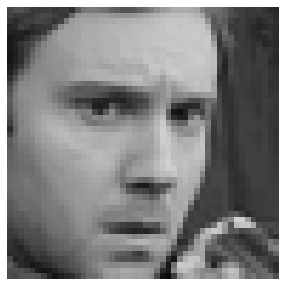

In [8]:
img = train['pixels'][0]
img = np.array(img.split(' ')).reshape(48,-1).astype('float')
plt.figure(figsize=(8,5))
plt.axis('off')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [10]:
label_map = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',\
            6:'Neutral'}
# just save one file for test
cv2.imwrite('../fer2013/train/{}/{}.jpg'.format(label_map[train['emotion'][0]], 1), img)

True

In [14]:
label_map = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',\
            6:'Neutral'}
for num, i in enumerate(train.index):
    img = train['pixels'][i]
    img = np.array(img.split(' ')).astype('float').reshape(48,-1)
    label = train['emotion'][i]
    cv2.imwrite('../fer2013/train/{}/{}.jpg'.format(label_map[label], num), img)

In [15]:
for num, i in enumerate(val.index):
    img = val['pixels'][i]
    img = np.array(img.split(' ')).astype('float').reshape(48,-1)
    label = val['emotion'][i]
    cv2.imwrite('../fer2013/validation/{}/{}.jpg'.format(label_map[label], num), img)

In [18]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 512

train_data_dir = '../fer2013/train'
validation_data_dir = '../fer2013/validation'

val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
print(validation_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [20]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)        

In [ ]:
# or we can just load pretrained model
model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_rows,img_cols,3), alpha=1.0,\
                        include_top=True, weights='imagenet', input_tensor=None,\
                                            pooling=None, classes=num_classes)
model.summary()

In [21]:
filepath = os.path.join("./emotion_detector_models/model_v6_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 28709
nb_validation_samples = 3589
epochs = 150
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')

Epoch 1/150
56/56 [==============================] - 148s 3s/step - loss: 1.9715 - accuracy: 0.1375 - val_loss: 1.9689 - val_accuracy: 0.1412
Epoch 2/150


C:\Users\user\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


56/56 [==============================] - 143s 3s/step - loss: 1.9669 - accuracy: 0.1443 - val_loss: 1.9647 - val_accuracy: 0.1529
Epoch 3/150
56/56 [==============================] - 152s 3s/step - loss: 1.9630 - accuracy: 0.1478 - val_loss: 1.9611 - val_accuracy: 0.1606
Epoch 4/150
56/56 [==============================] - 151s 3s/step - loss: 1.9587 - accuracy: 0.1624 - val_loss: 1.9471 - val_accuracy: 0.1825
Epoch 5/150
56/56 [==============================] - 153s 3s/step - loss: 1.9429 - accuracy: 0.1867 - val_loss: 1.9396 - val_accuracy: 0.2083
Epoch 6/150
56/56 [==============================] - 147s 3s/step - loss: 1.9076 - accuracy: 0.2128 - val_loss: 1.8624 - val_accuracy: 0.2508
Epoch 7/150
 4/56 [=>............................] - ETA: 2:12 - loss: 1.8639 - accuracy: 0.2373

KeyboardInterrupt: 

In [22]:
print(model_info.history.keys())

import matplotlib.pyplot as plt
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'model_info' is not defined